This is a one hidden layer GAN from Udacity's "Intro to GANs" Lesson from the Udacity Deep Learning Foundations Nanodegree: https://github.com/udacity/deep-learning/blob/master/gan_mnist/Intro_to_GANs_Solution.ipynb 
This GAN will serve as a baseline to measure performance against the moment stabilizing method.

In [1]:
%matplotlib inline
import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [4]:
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        h1 = tf.layers.dense(z, n_units, activation=None)
        h1 = tf.maximum(alpha * h1, h1)
        
        logits = tf.layers.dense(h1, out_dim)
        out = tf.tanh(logits)
        
        return out, logits

In [5]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.dense(x, n_units, activation=None)
        h1 = tf.maximum(alpha * h1, h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

<h2>Hyperparameters</h2>

In [6]:
input_size = 784
z_size = 100
g_hidden_size = 128
d_hidden_size = 128
alpha = 0.01
smooth = 0.1

In [7]:
tf.reset_default_graph()
input_real, input_z = model_inputs(input_size, z_size)

g_model, g_logits = generator(input_z, input_size)
d_model_real, d_logits_real = discriminator(input_real)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

In [8]:
d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))

In [9]:
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)

In [10]:
!mkdir checkpoints

mkdir: checkpoints: File exists


In [11]:
batch_size = 100
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))          
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
        losses.append((train_loss_d, train_loss_g))
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples, _ = sess.run(
                       generator(input_z, input_size, reuse=True),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/100... Discriminator Loss: 0.3677... Generator Loss: 3.8071
Epoch 2/100... Discriminator Loss: 0.3886... Generator Loss: 3.3726
Epoch 3/100... Discriminator Loss: 0.4659... Generator Loss: 4.3128
Epoch 4/100... Discriminator Loss: 0.4791... Generator Loss: 3.0440
Epoch 5/100... Discriminator Loss: 0.4649... Generator Loss: 3.6450
Epoch 6/100... Discriminator Loss: 0.7352... Generator Loss: 4.7793
Epoch 7/100... Discriminator Loss: 0.8217... Generator Loss: 2.2393
Epoch 8/100... Discriminator Loss: 0.6620... Generator Loss: 2.6741
Epoch 9/100... Discriminator Loss: 0.7968... Generator Loss: 2.8059
Epoch 10/100... Discriminator Loss: 0.7664... Generator Loss: 2.4236
Epoch 11/100... Discriminator Loss: 0.8223... Generator Loss: 3.1023
Epoch 12/100... Discriminator Loss: 1.3784... Generator Loss: 2.8367
Epoch 13/100... Discriminator Loss: 1.0323... Generator Loss: 2.1159
Epoch 14/100... Discriminator Loss: 1.1429... Generator Loss: 2.7668
Epoch 15/100... Discriminator Loss: 1.0355.

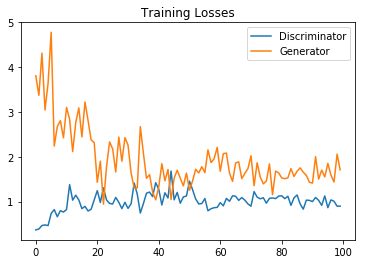

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [13]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

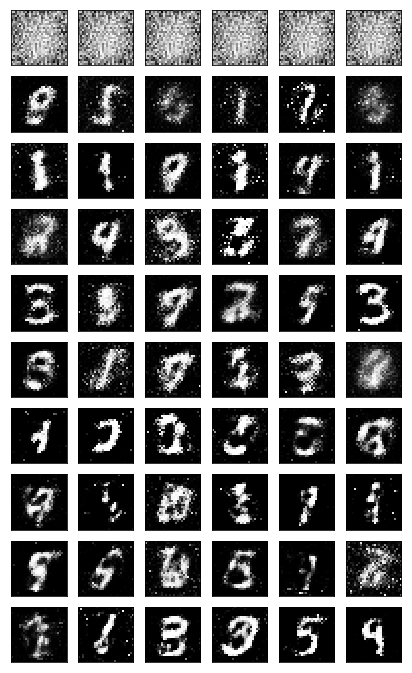

In [16]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)